开始使用梯度下降训练模型...
迭代 0: MSE = 5.584320
迭代 100: MSE = 1.096668
迭代 200: MSE = 0.956453
迭代 300: MSE = 0.855990
迭代 400: MSE = 0.783496
迭代 500: MSE = 0.730922
迭代 600: MSE = 0.692596
迭代 700: MSE = 0.664485
迭代 800: MSE = 0.643710
迭代 900: MSE = 0.628211
训练完成！

=== MSE评估结果 ===
训练集 MSE: 0.616512
验证集 MSE: 0.625164
测试集 MSE: 0.626887


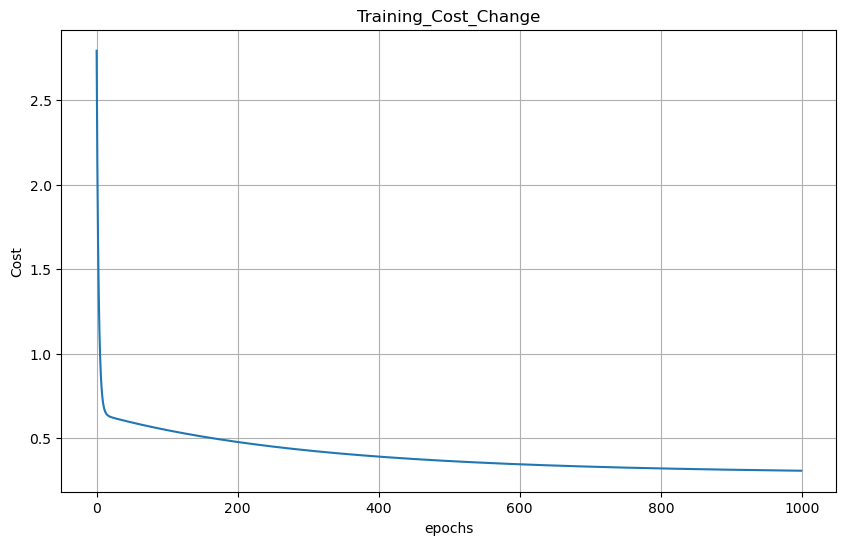

In [ ]:
import os
import numpy as np
import pandas as pd
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
from sklearn.utils import Bunch
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

# https://scikit-learn.org/stable/datasets.html
# Both loaders and fetchers functions return a Bunch object 
# holding at least two items: an array of shape n_samples * n_features
# with key 'data' (except for 20newsgroups) 
# and a numpy array of length n_samples, containing the target values, 
# with key 'target'

#  Bunch objects are sometimes used as an output for functions and methods.
#  They extend dictionaries by enabling values to be accessed by key,
#  `bunch["value_key"]`, or by an attribute, `bunch.value_key`.

#  本数据集还有：feature_nameslist of length 8
raw = fetch_california_housing(data_home='./cal_housing/')
# dataframe可以把字典转换为pandas表格，字典的一个键对应表格的一列
# df = pd.DataFrame(housing.data, columns=housing.feature_names) 
# samples是行，features是列

# 将列添加到DataFrame中
# df['target'] = housing.target

# 检查数据集信息，是否有缺失值等
# print(df.info())

# 经检查，数据集没有缺失值，转回Bunch对象做归一化和标准化
Standard_Scaler = StandardScaler()
MinMax_Scaler = MinMaxScaler()
raw_normalized = Standard_Scaler.fit_transform(raw.data)
raw_preprocessed = MinMax_Scaler.fit_transform(raw_normalized)

# 将处理后的数据转换回Bunch对象
california_housing = Bunch(data=raw_preprocessed, target=raw.target, feature_names=raw.feature_names, DESCR=raw.DESCR)

# 划分数据集为训练集，验证集和测试集(验证集用于调超参数：多个学习率和迭代次数择优)
# 本代码不涉及模型择优，只计算当前超参数的验证集MSE
# 60%训练集，20%验证集，20%测试集
X_train, X_temp, y_train, y_temp = train_test_split(california_housing.data, california_housing.target, test_size=0.4, random_state=42)
# 先分出0.4的剩余数据集，再划分验证集和测试集
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

class LinearRegression:
    def __init__(self, learning_rate=0.01, epochs=1000):
        self.learning_rate = learning_rate
        self.n_iterations = epochs
        self.weights = None
        self.bias = None
        self.cost_history = []  # 添加损失历史记录

    def fit(self, X, y):
        """使用梯度下降的 fit 方法"""
        n_samples, n_features = X.shape
        # python的解包赋值，X是一个ndarray，X.shape返回一个元组，包含行数和列数
        # n_samples = X.shape[0]  # 样本数量，行数
        # n_features = X.shape[1]  # 特征数量，列数
        
        # 初始化参数
        self.weights = np.zeros(n_features) 
        self.bias = 0  
        
        for i in range(self.n_iterations):
            # 1. 前向传播：计算预测值
            y_pred = X @ self.weights + self.bias
            
            # 2. 计算误差(下面计算梯度会用到)
            error = y_pred - y  # shape: (m,1)
            # 计算均方误差 (MSE)
            cost = (1/(2*n_samples)) * np.sum((error)**2) #numpy的*和**2都是矩阵对应元素的操作
            self.cost_history.append(cost)  # 记录损失历史
            
            
            # 3. 计算梯度
            # X.T @ error 计算每个特征的梯度
            # X.shape = (m, n), error.shape = (m,1)
            # X.T.shape = (n, m), X.T @ error.shape = (n,1)
            dw = (1/n_samples) * (X.T @ error)  # 对权重的梯度
            db = (1/n_samples) * np.sum(error)  # 对偏置的梯度
            
            # 4. 更新参数
            self.weights -= self.learning_rate * dw
            self.bias -= self.learning_rate * db
            
            # 计算当前损失
            if i % 100 == 0:
                mse = 2*cost
                print(f"迭代 {i}: MSE = {mse:.6f}")

    def predict(self, X):
        """使用当前模型参数进行预测"""
        return X.dot(self.weights) + self.bias
    
    def get_mse(self, X, y):
        """计算三个数据集的MSE"""
        y_pred = self.predict(X)
        return np.mean((y_pred - y) ** 2) # 沿向量方向的平均

def train_and_evaluate():
    """训练线性回归模型并评估性能"""
    # 创建模型
    model = LinearRegression(learning_rate=0.1, epochs=1000)
    
    # 训练模型
    print("开始使用梯度下降训练模型...")
    model.fit(X_train, y_train)
    print("训练完成！")
    
    # 计算MSE
    train_mse = model.get_mse(X_train, y_train)
    val_mse = model.get_mse(X_val, y_val)
    test_mse = model.get_mse(X_test, y_test)
    
    print(f"\n=== MSE评估结果 ===")
    print(f"训练集 MSE: {train_mse:.6f}")
    print(f"验证集 MSE: {val_mse:.6f}")
    print(f"测试集 MSE: {test_mse:.6f}")
    
    # 绘制MSE变化曲线
    import matplotlib.pyplot as plt
    plt.figure(figsize=(10, 6))
    plt.plot(model.cost_history)
    plt.title('Training_Cost_Change')
    plt.xlabel('epochs')
    plt.ylabel('Cost')
    plt.grid(True)
    plt.show()


train_and_evaluate()